## 1. Data Collection

### 1.1 Import Library

In [42]:
import os
import sys
import joblib
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import dump
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
# Warnings and logging
import warnings
import logging
warnings.filterwarnings("ignore")

# Append the correct src path for custom module imports
sys.path.append(os.path.abspath('../src'))
sys.path.append(os.path.abspath('../data'))
sys.path.append(os.path.abspath('../notebook/models'))
from custom_logging import info_logger, error_logger

In [2]:
from data_processing import load_data, clean_data, handle_missing_values
from sale_analysis import (
    plot_sales_distribution,
    compare_sales_holidays,
    seasonal_behavior,
    correlation_analysis,
    promo_effect,
    effective_promo_deployment,
    customer_behavior_trends,
    weekday_openings,
    assortment_type_impact,
    competitor_distance_impact,
    new_competitor_effects, 
    plot_promo_distribution,
    plot_sales_during_holidays,
    plot_sales_customers_corr, 
    plot_store_corr
)

2024-09-23 18:39:14,588 - INFO - Data loaded successfully from ../data/train.csv
2024-09-23 18:39:14,619 - INFO - Data loaded successfully from ../data/test.csv
2024-09-23 18:39:14,636 - INFO - Data loaded successfully from ../data/store.csv


### 1.2 Load the Data

In [4]:
# Load datasets
train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')
store_data = pd.read_csv('../data/store.csv')

## 2. Data Preprocesssing

#### 2.1 Summary of Dataset

In [5]:
train_data.dtypes

Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object

In [ ]:
train_data.describe()

In [6]:
test_data.dtypes

Id                 int64
Store              int64
DayOfWeek          int64
Date              object
Open             float64
Promo              int64
StateHoliday      object
SchoolHoliday      int64
dtype: object

In [7]:
store_data.dtypes

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [ ]:
store_data.describe()

### 2.2 Data Cleaning

In [8]:
#check missing values in training dataset
train_data.isna().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [9]:
# Check missing values in testing load_data
test_data.isna().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [10]:
# Check missing values on store data
store_data.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

### 2.3 Merge the dataset

In [11]:
# Merging the training and store data on Store ID
train_merged = pd.merge(train_data, store_data, on='Store', how='left')

# Merging the training and store data on Store ID
test_merged = pd.merge(test_data, store_data, on='Store', how='left')

# Final combined data
df = pd.concat([train_merged, test_merged], axis=0)

In [12]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Id
0,1,5,2015-07-31,5263.0,555.0,1.0,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,NaN
1,2,5,2015-07-31,6064.0,625.0,1.0,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",NaN
2,3,5,2015-07-31,8314.0,821.0,1.0,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",NaN
3,4,5,2015-07-31,13995.0,1498.0,1.0,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,NaN
4,5,5,2015-07-31,4822.0,559.0,1.0,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,NaN


In [13]:
df.shape

(1058297, 19)

In [14]:
# check missing values
df.isnull().sum()

Store                              0
DayOfWeek                          0
Date                               0
Sales                          41088
Customers                      41088
Open                              11
Promo                              0
StateHoliday                       0
SchoolHoliday                      0
StoreType                          0
Assortment                         0
CompetitionDistance             2738
CompetitionOpenSinceMonth     338564
CompetitionOpenSinceYear      338564
Promo2                             0
Promo2SinceWeek               525263
Promo2SinceYear               525263
PromoInterval                 525263
Id                           1017209
dtype: int64

### 2.4 Handling Missing Values

In [15]:
# Fill missing Sales and Customers with 0 (assuming the store was closed when Sales/Customers are missing)
df['Sales'].fillna(0, inplace=True)
df['Customers'].fillna(0, inplace=True)

# Fill missing 'Open' values with 0 (assuming store was closed when this is missing)
df['Open'].fillna(0, inplace=True)

# Fill missing CompetitionDistance with a large number indicating no nearby competition
df['CompetitionDistance'].fillna(df['CompetitionDistance'].max() + 1, inplace=True)

# Fill missing CompetitionOpenSinceMonth and Year with default values (e.g., month=1, year=2000)
df['CompetitionOpenSinceMonth'].fillna(1, inplace=True)  # Assume January as default month
df['CompetitionOpenSinceYear'].fillna(2000, inplace=True)  # Assume year 2000 as default year

# Fill missing Promo2-related columns with zeros or a default value indicating no promotion
df['Promo2SinceWeek'].fillna(0, inplace=True)
df['Promo2SinceYear'].fillna(0, inplace=True)
df['PromoInterval'].fillna('No Promo', inplace=True)

# Optionally drop the 'Id' column if you are not making predictions (for training purposes)
if 'Id' in df.columns:
    df.drop(columns=['Id'], inplace=True)

# Verify if there are still missing values
print(df.isnull().sum())


Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64


### 2.5 Feature Engineering

In [ ]:
# Convert datetime column to pandas datetime
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
# Extract date-based features
df['Day'] = df['Date'].dt.day
df['WeekOfYear'] = df['Date'].dt.isocalendar().week
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
df['IsBeginningOfMonth'] = df['Day'].apply(lambda x: 1 if x <= 7 else 0)
df['IsMidMonth'] = df['Day'].apply(lambda x: 1 if 8 <= x <= 21 else 0)
df['IsEndOfMonth'] = df['Day'].apply(lambda x: 1 if x > 21 else 0)

In [16]:
# Additional features: Days to nearest holidays
# add logic here to compute 'days to next holiday' and 'days after holiday' based on a holiday dataset.

# Label encode categorical features
categorical_features = ['StoreType', 'Assortment', 'PromoInterval']
label_encoder = LabelEncoder()
for col in categorical_features:
    df[col] = label_encoder.fit_transform(df[col].astype(str))

# Handle missing values, e.g., fill missing competition distance with the median
df['CompetitionDistance'].fillna(df['CompetitionDistance'].median(), inplace=True)

In [ ]:
# Scale the data
scaler = StandardScaler()
scaled_columns = ['CompetitionDistance', 'Day', 'WeekOfYear', 'Month', 'Year']
df[scaled_columns] = scaler.fit_transform(df[scaled_columns])


In [19]:
# Define the target (sales) and features
X = df.drop(columns=['Sales', 'Date'])
y = df['Sales']

### 2.7 Training the Pipeline model

In [20]:
# Check for non-numeric columns in the feature set
non_numeric_columns = X.select_dtypes(include=['object']).columns
print(f"Non-numeric columns: {non_numeric_columns}")

# Apply One-Hot Encoding to categorical columns (if any)
X_encoded = pd.get_dummies(X, columns=non_numeric_columns)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Define RandomForest model within a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Fit the model
pipeline.fit(X_train, y_train)


Non-numeric columns: Index(['StateHoliday'], dtype='object')


Pipeline(steps=[('scaler', StandardScaler()),
                ('model', RandomForestRegressor(random_state=42))])

### 2.3 Choose a loss function

In [21]:
# Define evaluation metrics
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

# Predict and evaluate
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

# Evaluate on training set
mse_train, mae_train, r2_train = evaluate_model(y_train, y_pred_train)
print(f"Training Set - MSE: {mse_train}, MAE: {mae_train}, R2: {r2_train}")

# Evaluate on test set
mse_test, mae_test, r2_test = evaluate_model(y_test, y_pred_test)
print(f"Test Set - MSE: {mse_test}, MAE: {mae_test}, R2: {r2_test}")


Training Set - MSE: 25598.328445346586, MAE: 94.3813865564581, R2: 0.9983469205312782
Test Set - MSE: 182804.90191507697, MAE: 253.74596702258341, R2: 0.9882147743913797


In [32]:
# Assuming 'model' is the trained RandomForestRegressor
importances = model.feature_importances_

# Check the length of feature_names to ensure consistency
print(f"Length of feature names: {len(feature_names)}")
print(f"Length of feature importances: {len(importances)}")

Length of feature names: 24
Length of feature importances: 28


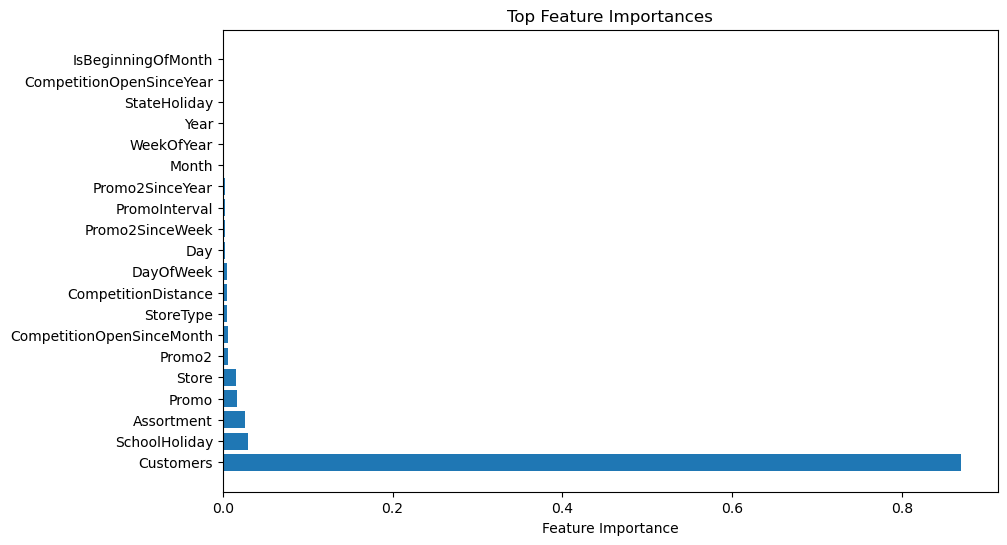

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming feature_importances and feature_names are aligned
feature_importances = model.feature_importances_  # Use the correct method to extract importance
sorted_idx = np.argsort(feature_importances)[::-1]  # Sort by importance

# Select the top 10 or all features for plotting
top_n = 20
sorted_idx = sorted_idx[:top_n]
sorted_feature_names = np.array(feature_names)[sorted_idx]
sorted_importances = feature_importances[sorted_idx]

plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importances, align='center')
plt.xlabel("Feature Importance")
plt.title("Top Feature Importances")
plt.show()

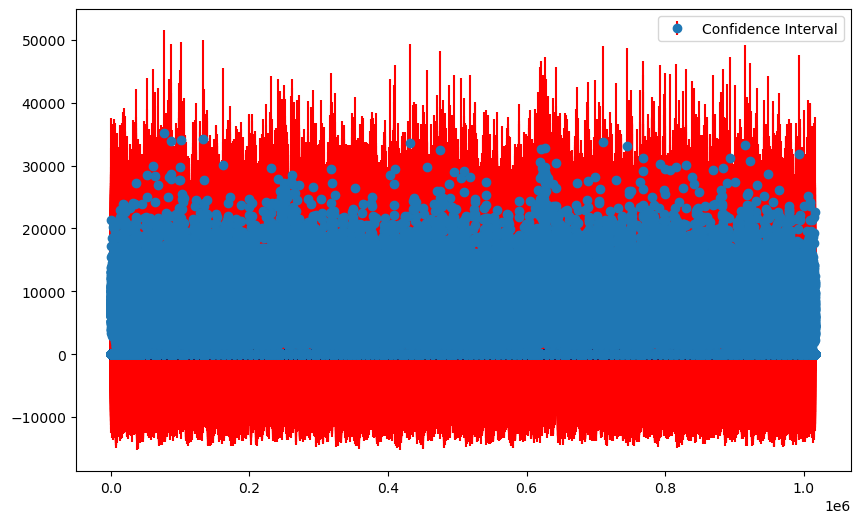

In [37]:
# Confidence Interval estimation (based on the standard deviation of predictions)
y_pred_std = np.std([tree.predict(X_test) for tree in model.estimators_], axis=0)
confidence_interval = 1.96 * y_pred_std  # 95% confidence interval
plt.figure(figsize=(10, 6))
plt.errorbar(y_test.index, y_pred_test, yerr=confidence_interval, fmt='o', ecolor='r', capthick=2, label="Confidence Interval")
plt.legend()
plt.show()

In [43]:
import os
import sys
import joblib
from datetime import datetime

# Correct the path
sys.path.append(os.path.abspath('../notebook/models'))

# Ensure the directory exists
os.makedirs('../notebook/models', exist_ok=True)

# Serialize model with timestamp
timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
model_filename = f"../notebook/models/sales_model_{timestamp}.pkl"
joblib.dump(pipeline, model_filename)

print(f"Model saved as {model_filename}")


Model saved as ../notebook/models/sales_model_2024-09-23-21-04-57.pkl


In [44]:
# 2.6 Building model with deep learning (LSTM)
# Prepare time series data
time_steps = 60

def create_lagged_data(data, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

sales = df['Sales'].values
scaled_sales = (sales - sales.mean()) / sales.std()  # Scale to (-1, 1)

# Create supervised learning data for LSTM
X_lstm, y_lstm = create_lagged_data(scaled_sales, time_steps)

# Split into train/test sets
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
    LSTM(50),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Reshape input for LSTM
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

# Train the model
history = model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=64, validation_data=(X_test_lstm, y_test_lstm))

# Predict with LSTM
y_pred_lstm = model.predict(X_test_lstm)
mse_lstm = mean_squared_error(y_test_lstm, y_pred_lstm)
print(f"LSTM Model - Test Set MSE: {mse_lstm}")

Epoch 1/10
13228/13228 ━━━━━━━━━━━━━━━━━━━━ 717s 54ms/step - loss: 0.4163 - val_loss: 0.3277
Epoch 2/10
13228/13228 ━━━━━━━━━━━━━━━━━━━━ 583s 44ms/step - loss: 0.2910 - val_loss: 0.2223
Epoch 3/10
13228/13228 ━━━━━━━━━━━━━━━━━━━━ 559s 42ms/step - loss: 0.2075 - val_loss: 0.1804
Epoch 4/10
13228/13228 ━━━━━━━━━━━━━━━━━━━━ 588s 44ms/step - loss: 0.1678 - val_loss: 0.2129
Epoch 5/10
13228/13228 ━━━━━━━━━━━━━━━━━━━━ 587s 44ms/step - loss: 0.1524 - val_loss: 0.1413
Epoch 6/10
13228/13228 ━━━━━━━━━━━━━━━━━━━━ 576s 44ms/step - loss: 0.1361 - val_loss: 0.1335
Epoch 7/10
13228/13228 ━━━━━━━━━━━━━━━━━━━━ 553s 42ms/step - loss: 0.1312 - val_loss: 0.1389
Epoch 8/10
13228/13228 ━━━━━━━━━━━━━━━━━━━━ 592s 45ms/step - loss: 0.1237 - val_loss: 0.1246
Epoch 9/10
13228/13228 ━━━━━━━━━━━━━━━━━━━━ 781s 59ms/step - loss: 0.1182 - val_loss: 0.1234
Epoch 10/10
13228/13228 ━━━━━━━━━━━━━━━━━━━━ 537s 41ms/step - loss: 0.1125 - val_loss: 0.1162
6614/6614 ━━━━━━━━━━━━━━━━━━━━ 66s 10ms/step
LSTM Model - Test Set MS

In [45]:
# Calculate predictions
y_pred_lstm = model.predict(X_test_lstm)

# Rescale predictions back to original values
y_pred_lstm_rescaled = y_pred_lstm * sales.std() + sales.mean()
y_test_lstm_rescaled = y_test_lstm * sales.std() + sales.mean()

# Calculate metrics
mae_lstm = mean_absolute_error(y_test_lstm_rescaled, y_pred_lstm_rescaled)
mse_lstm = mean_squared_error(y_test_lstm_rescaled, y_pred_lstm_rescaled)
r2_lstm = r2_score(y_test_lstm_rescaled, y_pred_lstm_rescaled)

print(f"LSTM Model - Test Set MAE: {mae_lstm:.2f}")
print(f"LSTM Model - Test Set MSE: {mse_lstm:.2f}")
print(f"LSTM Model - Test Set R²: {r2_lstm:.2f}")

6614/6614 ━━━━━━━━━━━━━━━━━━━━ 70s 11ms/step
LSTM Model - Test Set MAE: 769.34
LSTM Model - Test Set MSE: 1799419.38
LSTM Model - Test Set R²: 0.88


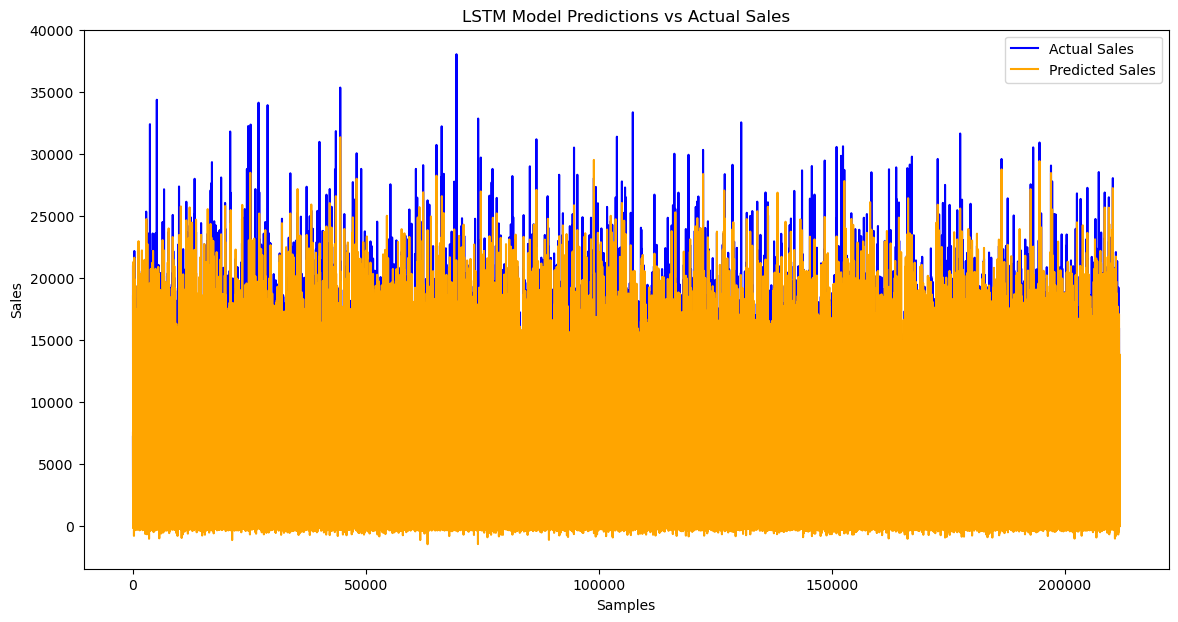

In [46]:
import matplotlib.pyplot as plt

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(y_test_lstm_rescaled, label='Actual Sales', color='blue')
plt.plot(y_pred_lstm_rescaled, label='Predicted Sales', color='orange')
plt.title('LSTM Model Predictions vs Actual Sales')
plt.xlabel('Samples')
plt.ylabel('Sales')
plt.legend()
plt.show()


In [48]:
import joblib
from datetime import datetime

# Define a filename with a timestamp
timestamp = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
lstm_model_filename = f"../notebook/models/lstm_model_{timestamp}.h5"

# Save the model
model.save(lstm_model_filename)
print(f'LSTM model serialized to {lstm_model_filename}')


2024-09-23 22:55:33,051 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


LSTM model serialized to ../notebook/models/lstm_model_2024-09-23-22-55-33.h5


In [ ]:
#